## Loan Pricing ##
<hr class="header-line"/>

Pricing of a loan, just like any other product, is influenced by both the cost to produce and the market.

<p class="p-break"></p>

And so there are two methods to deriving an interest rate for a loan:

1. Capital-Driven:
    + what interest rate is required to justify the allocation of capital?

2. Market-Driven:
    + what rate is implied in the market?
    + derived from various market-related exposures
    
The two methods are *not* exclusive. Fico should consider both approaches when loan pricing as circumstances may reveal information:

<p class="p-break"></p>

$\text{Market-Driven Rate} >>> \text{Capital Driven Rate}$

+ Fico either has some competitive advantage *or* it is underpricing risk

<p class="p-break"></p>

$\text{Capital Driven Rate} >>> \text{Market-Driven Rate}$

+ Fico has a competitive disadvantage *or* it is overpricing risk

<p class="p-break"></p>
<p class="p-break"></p>

### Capital Driven ###

+ Loan income is compared to a *hurdle rate*, which can be set as the Weighted Average Cost of Capital (WACC) for the company/investor/project.

$$
\text{WACC} = r_{tgt} = w_{debt}*r_{debt} + w_{equity}*r_{equity} 
$$
$\qquad\qquad\qquad\qquad\qquad\textit{where:}$
$$
\\w_{debt} = \frac{D}{D+E}
$$

$\qquad$or simply as the cost of equity, to take the investor perspective:
   
$$ r_{tgt} = r_{equity} $$

$\qquad$ The hurdle rate may also be set relative to other investment opportunities (and thereby seen as an opportunity cost).

<p class="p-break"></p>

+ The interest rate required *for an individual loan* to meet the hurdle rate is:

$$
\begin{alignat*}{0}
\qquad\text{int}_i = \frac{r_{tgt}*(D_i+E_i) + exp_i}{EAD_i}
\\\textit{where:}
\\\qquad exp_i = \text{expected losses + non-recovery related expenses like salaries, taxes, etc.}
\\\qquad D_i, E_i = \text{debt and equity contribution required for the individual loan}
\\\qquad D_i + E_i = EAD_i
\end{alignat*}
$$



**Equity Only**

We will estimate pricing for loans where Fico is funded entirely by equity.

<p class="p-break"></p>

Assume:

+ $r_{tgt} = .12$
+ $exp_i = EL_i$ i.e. Fico has no expenses save for loan losses
+ Supported entirely by equity capital

For this exercise, we created a new portfolio via the approach in [loss models](loss.ipynb) with the following properties:

In [49]:
%load_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.ticker import FuncFormatter
from IPython.core.display import display, HTML, Markdown
from IPython.display import Image

import dataframe_image as dfi

import sys
sys.path.append('..')
from htsfi.main import *

update_style()
plt.style.use('htsfi')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    from htsfi.sims.pricing import *

md = f'+ Number of Loans: {n}'
md += '\n\n'
md += f'+ Total Outstanding: ${EAD.sum():,.0f}'
md += '\n\n'
md += f'+ Expected Loss: ${ld.mean():,.2f}'
md += '\n\n'
md += f'+ Required Equity (99.95% VaR): ${econ_cap:,.2f}'
md += '\n\n'

display(Markdown(md))

+ Number of Loans: 20

+ Total Outstanding: $2,000,000

+ Expected Loss: $15,342.64

+ Required Equity (99.95% VaR): $224,846.27



<p class="p-break"></p>

With that portfolio distribution, we now want to consider how to price 3 loans in the portfolio. The loans have details as follows:

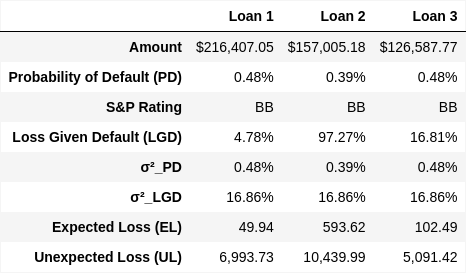

In [51]:
# Loan Portfolio
n = 3
loans_t = 5*10**5
randloans = np.random.uniform(0.1,1,n)
loan_ead = (randloans / randloans.sum())*loans_t
w = loan_ead / loan_ead.sum()

# PD for each borrower/loan.
pd_mu = 0.0044
pd_std = 0.002
p_of_d = np.random.normal(pd_mu, pd_std, n)
count, bins = np.histogram(p_of_d, bins=PDs)
binned = np.digitize(p_of_d, bins)
rats = np.array(SPs)[binned]

p_of_d = np.where(p_of_d<0, 0, p_of_d)

pd_var = bern.var(p_of_d)     # PD for each individual loan is bernoulli distributed and has its own variance.

# LGD
lgd_mu = .4
lgd_std = .4

a, b = beta_params_from_descript(lgd_mu, lgd_std**2)
lgd_freeze = beta(a, b)
lgd = lgd_freeze.rvs(size=n)

lgd_var = np.repeat(lgd.var(), n)

el = loan_ead*p_of_d*lgd
ul = loan_ul(loan_ead, p_of_d, lgd, pd_var, lgd_var)

# Convert HTML table to DataFrame
data = {
    'Amount': loan_ead,
    'Probability of Default (PD)': p_of_d,
    'S&P Rating': rats,
    'Loss Given Default (LGD)': lgd,
    'σ²_PD': pd_var,
    'σ²_LGD': lgd_var, 
    'Expected Loss (EL)': el,
    'Unexpected Loss (UL)': ul
}

df = pd.DataFrame(data)
df.index = [f'Loan {i+1}' for i in range(n)]

# Format the columns
df['Amount'] = df['Amount'].map('${:,.2f}'.format)
df['Probability of Default (PD)'] = df['Probability of Default (PD)'].map('{:.2%}'.format)
df['Loss Given Default (LGD)'] = df['Loss Given Default (LGD)'].map('{:.2%}'.format)
df['σ²_PD'] = df['σ²_PD'].map('{:.2%}'.format)
df['σ²_LGD'] = df['σ²_LGD'].map('{:.2%}'.format)
df['Expected Loss (EL)'] = df['Expected Loss (EL)'].map('{:,.2f}'.format)
df['Unexpected Loss (UL)'] = df['Unexpected Loss (UL)'].map('{:,.2f}'.format)

# Save as PNG using dataframe_image
await dfi.export_async(df.T, '_static/pricing_3_loan_portfolio_table.png')
Image(filename='_static/pricing_3_loan_portfolio_table.png')

We can do quick math on each loan to find the interest rate required to meet hurdle:

In [52]:
def calc_ret(rev, exp, cap):
    return (rev - exp) / cap

def int_to_make_hurdle(exp, loan, equity, hurdle):
    return (hurdle*equity + exp) / loan

hurdle = .12
exp = el

debt = 0
equity = loan_ead
req_int = int_to_make_hurdle(exp, loan_ead, equity, hurdle)

In [53]:
loan_metrics_df = pd.DataFrame({
    'Amount': loan_ead,
    'Probability of Default (PD)': p_of_d,
    'Loss Given Default (LGD)': lgd,
    'Expected Loss (EL)': el,
    'Required Interest Rate': req_int
})

# Add loan numbers as column names
loan_metrics_df.index = [f'Loan {i+1}' for i in range(n)]
loan_metrics_df = loan_metrics_df.style.format({
    'Amount': '{:,.2f}',
    'Probability of Default (PD)': '{:.2%}',
    'Loss Given Default (LGD)': '{:.2%}',
    'Expected Loss (EL)': '{:,.2f}',
    'Required Interest Rate': '{:.2%}'
})
await dfi.export_async(loan_metrics_df, '_static/pricing_3_loan_metrics_table.png')
Image(filename='_static/pricing_3_loan_metrics_table.png')

Unsurprisingly, even the lowest risk loan requires at least 12% interest rate. This is way above market for these types of loans.

<p class="p-break"></p>

Leverage can be utilized to lower the hurdle rate.

<p class="p-break"></p>

**Mix of Debt and Equity**

To show how we can incorporate leverage, we modify our assumptions. For each loan, we will assume that we only need to hold the UL for each loan as equity. The rest of Fico's capital will be debt, borrowed at 3%.

<p class="p-break"></p>

Assume:

+ $r_{tgt} = .12$
+ $E_i = UL_i$
+ $D_i = EAD_i - E_i$
+ $exp_i = EL_i + D_i*r_{debt}$
+ $r_{debt} = .03$

In [42]:
equity = ul
debt = loan_ead - equity

cost_of_debt = .03
int_on_debt = debt * cost_of_debt
exp = el + int_on_debt

req_int = int_to_make_hurdle(exp, loan_ead, equity, hurdle)

In [44]:
# Create a pandas DataFrame from the loan data
data = {
    'Amount': loan_ead,
    'Probability of Default (PD)': p_of_d,
    'Loss Given Default (LGD)': lgd, 
    'Expected Loss (EL)': el,
    'Required Interest Rate': req_int
}

df_loan_metrics_w_leverage = pd.DataFrame(data)
df_loan_metrics_w_leverage.index = [f'Loan {i+1}' for i in range(n)]


In [45]:
df_loan_metrics_w_leverage.style.format({
    'Amount': '{:,.2f}',
    'Probability of Default (PD)': '{:.2%}',
    'Loss Given Default (LGD)': '{:.2%}',
    'Expected Loss (EL)': '{:,.2f}',
    'Required Interest Rate': '{:.2%}'
})

,Amount,Probability of Default (PD),Loss Given Default (LGD),Expected Loss (EL),Required Interest Rate
Loan 1,"82,910.46",0.41%,1.57%,5.30,3.28%
Loan 2,"204,794.39",0.00%,98.75%,0.00,3.00%
Loan 3,"212,295.15",0.67%,0.88%,12.50,3.35%


In [ ]:

await dfi.export_async(df_loan_metrics_w_leverage.style.format({
    'Amount': '{:,.2f}',
    'Probability of Default (PD)': '{:.2%}',
    'Loss Given Default (LGD)': '{:.2%}',
    'Expected Loss (EL)': '{:,.2f}',
    'Required Interest Rate': '{:.2%}'
}), '_static/pricing_3_loan_metrics_table_w_leverage.png')

Image(filename='_static/pricing_3_loan_metrics_table_w_leverage.png')

We can see how the mix of debt and equity has helped to improve loan pricing, which should make Fico more competitive in the market place.

<p class="p-break"></p>


## Market Driven ##

Interest rates charged on government bonds, corporate debt, or any other loan are generally understood to be derived from the following components:

1. Real risk-free rate
    + generalyl understood to be a function of the "inherent" time value of money, which requires an incentive to delay consumption.
    + I actually believe it has more to do with increasing real consumption; my working theory is the real risk-free is the value-add created by increasing consumption.
2. Inflation premium
3. Liquidity premium
    + understood as relative cost to sell the debt
    + smaller amounts, poorer credit risks, less desirable jurisdictions, lower coupons
4. Credit Risk premium
5. Margin
    + in an efficient bond market, pricing theory dictates that there would be not "profit" to the holder (or the issuer).
    + but as a service provider, margin can be incorporated

These factors are observable, although every borrower / loan has its unique qualities that will alter the components slightly from observable values.

So all-in rate derived as:

$$r + r_{inf} + r_{lqd} + r_{cred} + r_{prof}$$

We can infer the components from available market data, such as this chart of corporate bond yields.

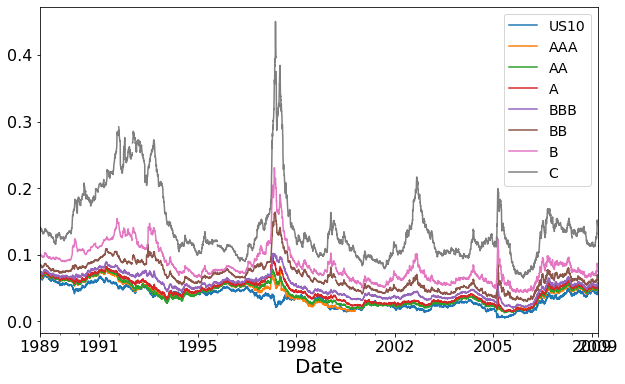

In [27]:
yields = get_yields()
ax = yields.plot(figsize=(10,6))

ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params('x', labelrotation=0)

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    
plt.show()

In [28]:
infsers = ['DGS10', 'DFII10', 'T10YIE']
frames = [framer(ser) for ser in infsers]

infs = frames[0]
for f in frames[1:]:
    infs = infs.merge(f, on='Date')
infs = infs.set_index('Date')

infs = infs.apply(numeric_coerce)
infs.columns = ['US10', 'US10-R', 'Inf10-E']
infs /= 100

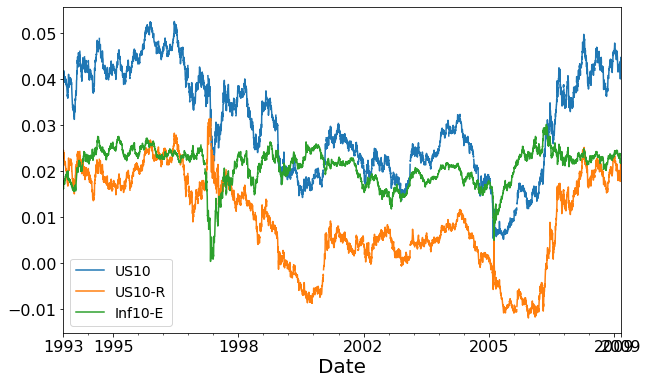

In [29]:
ax = infs.plot(figsize=(10,6))

ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params('x', labelrotation=0)

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    
plt.show()

In [30]:
us, real, inf = infs.iloc[-1].to_list()

In [31]:
text = r'$r + r_{inf}$' + f' = {real:.2%} + {inf:.2%}' + f' = {real+inf:.2%}'
text += '\n\n'
text += f'US 10 Year = {us:.2%}'
display(Markdown(text))

$r + r_{inf}$ = 2.11% + 2.23% = 4.34%

US 10 Year = 4.34%

In [32]:
aaa = yields.AAA.iloc[-1]
lqd = aaa - us

In [33]:
text = f'AAA Corp = {aaa:.2%}'
text += '\n\n'
text += r'$r_{lqd} = r_{aaa} - r - r_{inf}$' + f' = {aaa:.2%} {real:.2%} - {inf:.2%} = {lqd:.2%}'
display(Markdown(text))

AAA Corp = 4.78%

$r_{lqd} = r_{aaa} - r - r_{inf}$ = 4.78% 2.11% - 2.23% = 0.44%

In [34]:
bbb = yields.BBB.iloc[-1]
cred = bbb - aaa

In [35]:
text = f'BBB Corp = {bbb:.2%}'
text += '\n\n'
text += r'$r_{cred} = r_{bbb} - r - r_{inf} - r_{lqd}$' + f' = {bbb:.2%} - {real:.2%} - {inf:.2%} - {lqd:.2%}= {cred:.2%}'
display(Markdown(text))

BBB Corp = 5.60%

$r_{cred} = r_{bbb} - r - r_{inf} - r_{lqd}$ = 5.60% - 2.11% - 2.23% - 0.44%= 0.82%

In [36]:
text = r'$r + r_{inf} + r_{lqd} + r_{cred}$'
text += '\n\n'
text += f' = {real:.2%} + {inf:.2%} + {lqd:.2%} + {cred:.2%}'
text += '\n\n'
text += f' = {bbb:.2%}'
display(Markdown(text))

$r + r_{inf} + r_{lqd} + r_{cred}$

 = 2.11% + 2.23% + 0.44% + 0.82%

 = 5.60%